## Shadman Sakib
### _Submission Date: 14-01-2018_

---
# House Prices: Advanced Regression Techniques
---





# Abstract
---
This project is about predicting the price of a house based on several attributes. The prediction is to be done using Machine Learning. The train dataset consists of 1460 samples of residential homes in Ames, Iowa. There are 79 variables describing various aspects of each house. 
The procedure consist of dataset analysis, feature selection, data preprocessing and model selection. Different data visualization techniques are used throughout the project when required. In this project, the main focus was Neural Network. So, no other algorithm was used. 

# 1. Dataset Analysis & Feature Selection
---

### _Import all the libraries_

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import norm, skew, probplot
from scipy.special import inv_boxcox
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.feature_selection import RFE, RFECV
import itertools

from scipy.stats import boxcox

import xgboost

import tensorflow as tf

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, Reshape, BatchNormalization
from keras import regularizers
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

from keras.layers.advanced_activations import PReLU , LeakyReLU

%matplotlib inline

## _1.1. Basic Feature Extraction:_

In [121]:
#Reading the Dataset
train = pd.read_csv('train.csv')  # Train
test = pd.read_csv('test.csv')    # Test

#Taking away the features
feature = train.drop(['Id','SalePrice'], axis=1)   # Train
test_ID = test[['Id']]
test = test.drop(['Id'], axis=1)            # Test

#Slicing the 'Price' field to make the target data
target = train[['SalePrice']]

#Let's check the shape of the data
print('Feature: ',feature.shape)
print('Target: ', target.shape)
print('Test', test.shape)


Feature:  (1460, 79)
Target:  (1460, 1)
Test (1459, 79)


## _1.2. Feature Dropping Based on NA Percentage :_

We will first investigate the missing values in the dataset.

In [122]:
na_percent = pd.isnull(feature).sum()*100/len(feature)
print(na_percent)
high_na = na_percent[na_percent>=20]
print('Columns with high percentage of NA (Above 20%)')
print(high_na)

MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
Street            0.000000
Alley            93.767123
LotShape          0.000000
LandContour       0.000000
Utilities         0.000000
LotConfig         0.000000
LandSlope         0.000000
Neighborhood      0.000000
Condition1        0.000000
Condition2        0.000000
BldgType          0.000000
HouseStyle        0.000000
OverallQual       0.000000
OverallCond       0.000000
YearBuilt         0.000000
YearRemodAdd      0.000000
RoofStyle         0.000000
RoofMatl          0.000000
Exterior1st       0.000000
Exterior2nd       0.000000
MasVnrType        0.547945
MasVnrArea        0.547945
ExterQual         0.000000
ExterCond         0.000000
Foundation        0.000000
BsmtQual          2.534247
                   ...    
HalfBath          0.000000
BedroomAbvGr      0.000000
KitchenAbvGr      0.000000
KitchenQual       0.000000
TotRmsAbvGrd      0.000000
Functional        0.000000
F

Some of the columns have a huge percentage of NA value. At first glance, It might seem logical to them. But if we take a closer look and read the data description, there are some columns which have NAN value where that attribute is not available for that sample. Which means it is 0. Alley, FireplaceQu, PoolQC, Fence etc are those kind of fields. All of them have high percentage of NAN value. But if fact they seem to represent some important attributes and may have hugh impact on the target. So, instead of dropping them, we will replace their NANs with 0.

In [123]:
zero_col = ['MiscFeature','MiscVal', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish','GarageQual', 
            'GarageCond', 'PoolQC','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
            'BsmtFinType2', 'MasVnrType', 'Alley','GarageArea',
            'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
            'BsmtHalfBath', 'MasVnrArea', 'MasVnrArea']
for items in zero_col:
    feature[items] = feature[items].fillna(0)
    test[items] = test[items].fillna(0)

## _1.3. Corelation with the target:_

At this point, we will first see the corelation of the features with the target.

(1460, 80)


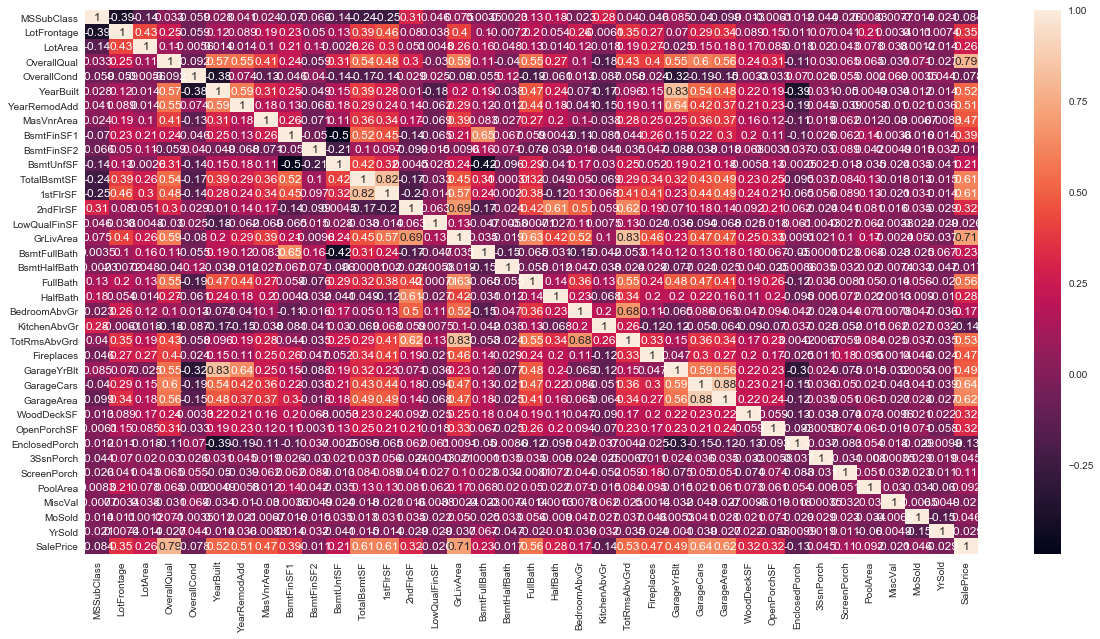

In [124]:
#Combining Target and feature
new_data = pd.concat([feature, target] , axis=1)
print(new_data.shape)

#Corelation Matrix
cormat = new_data.corr()

#Visualization
sns.set()
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.heatmap(cormat, annot=True)
fig = fig.get_figure()
fig.savefig('pair_all.png')

We can see there are many features which are not that much corelated with the saleprice. Using these features will unnecessarily increase the complexity of the model. So, we'll drop them. In order to do that, we need to find out the most corelated features first.
But before that, we need to encode the categorical features. 

## _1.4. Converting categorical features to numeric:_
    
   All the machine Learning algorithms need numeric values as input. So, we need to convert the categorical features into numeric values. We need to convert some of the columns with numeric values too. As their number means different class.  

In [125]:
#Convert datatypes of the numeric columns which actually means different classes
feature['MoSold']= feature['MoSold'].astype(str)
test['MoSold']= test['MoSold'].astype(str)
feature['MSSubClass']= feature['MSSubClass'].astype(str)
test['MSSubClass']= test['MSSubClass'].astype(str)
print(feature.shape)
print(test.shape)

#Convert categorical features with string labels.
feature= pd.get_dummies(feature)
test= pd.get_dummies(test)
print(feature.shape)
print(test.shape)

(1460, 79)
(1459, 79)
(1460, 328)
(1459, 311)


There are less columns in test set than train set. This is because of the fact that all the categories are not present in the test set. We have to add them manually.
However, there is one special case. The Test Dataset has a sample where the value of MSSubClass is 150. In train data, this value is not present. So, we will add it first.

In [126]:
feature = feature.assign(MSSubClass_150=0)

TrnCol = feature.columns.tolist()
TstCol = test.columns.tolist()
print('Columns in Train Set')
print('==================================')
print(TrnCol)
print('Columns in Test Set')
print('==================================')
print(TstCol)
NewCol = TrnCol
for x in TstCol:
    print(x)
    NewCol.remove(x)
print('Columns to be added')
print('==================================')
print(NewCol)
print('==================================')
print('==================================')

for x in NewCol:
    test[x]=0
    
print(feature.shape)
print(test.shape)

Columns in Train Set
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_0', 'Alley_Grvl', 'Alley_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContou

(1460, 330)
['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'ScreenPorch', 'PoolArea', 'MSSubClass_60', 'MSZoning_FV', 'MSZoning_RL', 'Alley_0', 'LotShape_IR1', 'LotShape_IR2', 'LandContour_HLS', 'LotConfig_CulDSac', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Condition1_Norm', 'BldgType_1Fam', 'HouseStyle_2Story', 'RoofStyle_Hip', 'RoofMatl_WdShngl', 'Exterior1st_CemntBd', 'Exterior1st_VinylSd', 'Exterior2nd_CmentBd', 'Exterior2nd_ImStucc', 'Exterior2nd_VinylSd', 'MasVnrType_BrkFace', 'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Gd', 'ExterCond_TA', 'Foundation_PConc', 'BsmtQual_Ex', 'BsmtQua

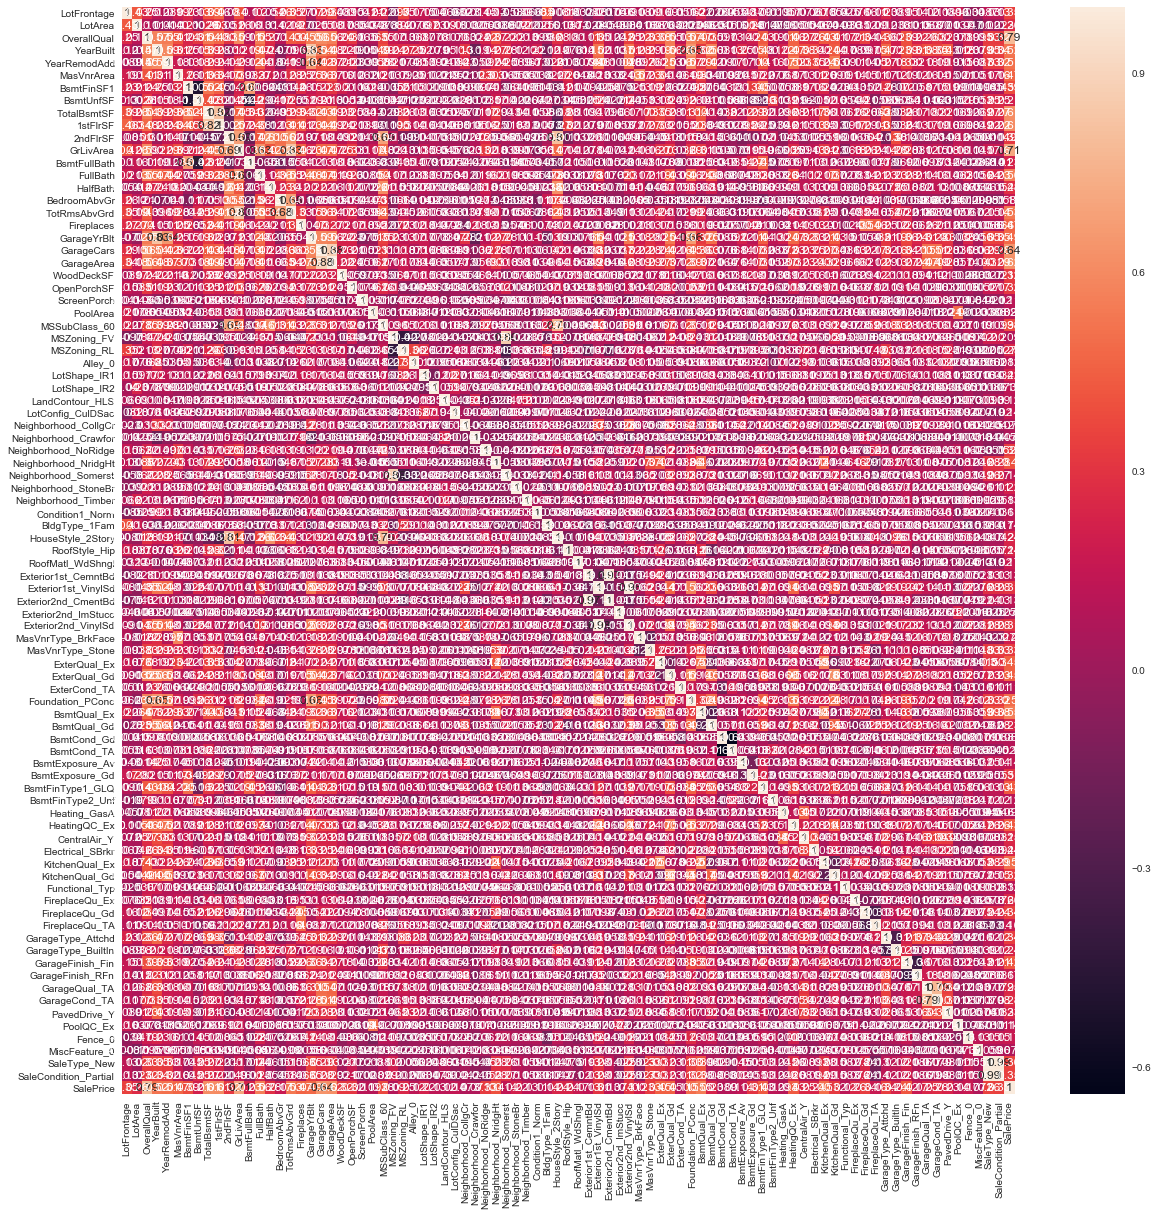

In [127]:
# New COrelation Matrix
new_data = pd.concat([feature, target] , axis=1)
print(new_data.shape)

#Corelation Matrix
cormat = new_data.corr()

#Top Corelated columns

top_col = cormat.index[abs(cormat['SalePrice']>=.07)].tolist()

print(top_col)

#Corelation Matrix of the top columns
top_cor = new_data[top_col]
top_cor = top_cor.corr()
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.heatmap(top_cor, annot=True)

#Remove the 'SalePrice' column
top_col.remove('SalePrice')

#Slice the top-impact features
feature = feature[top_col]
test = test[top_col]


print(feature.shape)
print(test.shape)

## _1.5. Feature Engineering:_

After the top-impact feature extraction, we can see that some features can be merged to make another which is more meaningful. These are:
<ul>
<li>As 1stFlrSF is an important feature, we can add _totFlrSF = 1stFlrSF + 2ndFlrSF_ as a feature. The 2ndFlrSF is not in the cop-impact list probably because of the fact that many house do not have 2nd floor</li>
<li>As YearBuilt is an important feature, we can add _'Age' = YrSold - YearBuilt_ as a feature </li>
<li>For the same reason, _NewAge = YrSold - YearRemodAdd_ might be a good feature </li>
</ul>

In [128]:
print(feature.shape)
print(test.shape)

# Add to train set
totFlrSF = train['1stFlrSF'].add(train['2ndFlrSF'])
Age = train.YrSold - train.YearBuilt
NewAge = train.YrSold - train.YearRemodAdd

feature = pd.concat([feature, totFlrSF, Age, NewAge ] , axis=1)
feature = feature.drop(['1stFlrSF','2ndFlrSF'], axis=1)

# Add to test set
temp_test = pd.read_csv('test.csv')

totFlrSF = temp_test['1stFlrSF'].add(temp_test['2ndFlrSF'])
Age = temp_test.YrSold - temp_test.YearBuilt
NewAge = temp_test.YrSold - temp_test.YearRemodAdd

test = pd.concat([test, totFlrSF, Age, NewAge ] , axis=1)
test = test.drop(['1stFlrSF','2ndFlrSF'], axis=1)

#See the shape
print(feature.shape)
print(test.shape)

(1460, 86)
(1459, 86)
(1460, 87)
(1459, 87)


# _1: Summary:_

<ul>
<li>Loaded The Datasets</li>
<li>Isolated features and target</li>
<li>Identified and analyzed features having above high percentage of missing value</li>
<li>Some features (having high percentage of NAN value) contans NAN when that attribute is missing. So, we replaced their NANs with 0</li>
<li>Dropped features having less than a threshold percentage of corelation with the target </li>
<li>Some new features are created based on some original ones.</li>
</ul>


# 2. Data Preprocessing
---

## _2.1. Missing Data Handling:_ 

All the missing data will be filled with the median of that feature column.

In [129]:
feature=feature.fillna(feature.median())
test=test.fillna(feature.median())

## _2.2. Outlier Handling:_

   For detecting the outliers, I will use the IsolationForest method. Dropping the outliers can make the model more generalized. But in contrast, it may again destroy it's robustness. So, the percentage of anomality is a very important parameter here.

In [130]:
clf = IsolationForest(contamination=.05)
clf.fit(feature)
out_lier = clf.predict(feature).tolist()
out_count = 0
pos = []
for x in range(len(out_lier)):
    if(out_lier[x]==-1):
        out_count = out_count+1
        pos.append(x)
print('Number of outliers: ',out_count)
feature  = feature.drop(feature.index[pos])
target = target.drop(target.index[pos])

feature.reset_index(drop = True, inplace = True)
target.reset_index(drop = True, inplace = True)

Number of outliers:  73


Now we will go through the pair plots of each feature with the target to identify the outliers. But all of them shouldn't be deleted as the combined relationship of the features to the target is complex. Here we deleted only a few samples based on the most influential features.

### Let's check...

In [131]:
print(feature.shape)
print(target.shape)
print(test.shape)

#Reshape the target vector
target = target['SalePrice']

print(feature.shape)
print(target.shape)
print(test.shape)

(1387, 87)
(1387, 1)
(1459, 87)
(1387, 87)
(1387,)
(1459, 87)


## _2.3. Scaling & Normalizing:_

The ANN needs the input to  be normalized. Here, I used the StandardScaler to do that. Then I used some combinations of different scalers and transformers and noted their effects. The QuantileTransformer reduces the overfitting while keeping the accuracy high. 

In [132]:
#Scaler
scaler = StandardScaler()
#scaler = MinMaxScaler()

#Transformer
#QT = QuantileTransformer()


#QT.fit(feature)
#feature = QT.transform(feature)

#Apply on train dataset
scaler.fit(feature)
feature = scaler.transform(feature)

#Apply on test dataset
#test = QT.transform(test)
test = scaler.transform(test)


## _2.4. Probability distribution:_

   Most of the algorithms by default assume that the target follows a normal distribution. If that is not the case, then, the accuracy falls. In this section, we will take a look at the 'SalePrice' from a probabilistic viewpoint and transform it if necessary.

Let's check the present distribution and compare it with standard bell curve

0.9709255583059769


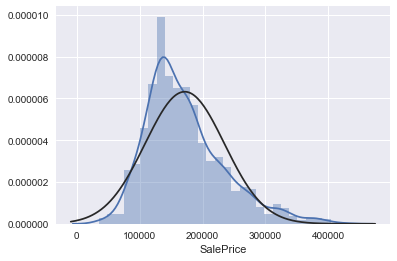

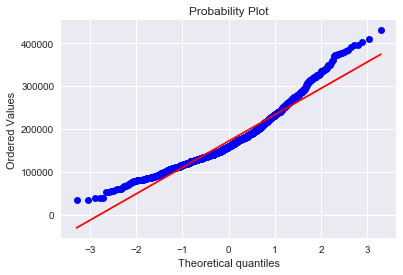

In [133]:
sns.distplot(target, fit=norm)
sk = skew(target)
print(sk)

fig = plt.figure()
res = probplot(target, plot=plt)
plt.show()

We can see that the target data is skewed. Therefore, it do not show linearity in the probability plot. To remove the skewness, we need to transform the data using coxbox.

0.0068473477244549805
0.14263991777494509


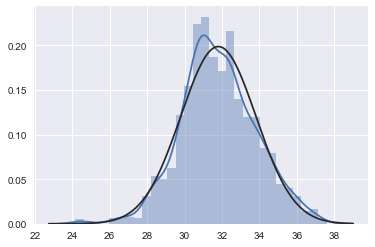

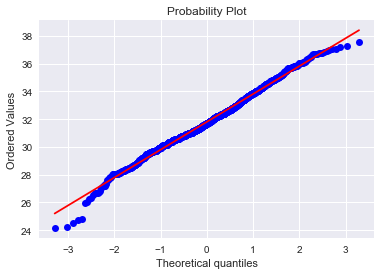

In [134]:
target, lmbda = boxcox(target)

sns.distplot(target, fit=norm)
sk = skew(target)
print(sk)
print(lmbda)

fig = plt.figure()
res = probplot(target, plot=plt)
plt.show()


Now, it looks better. And we can go to the next and final phase..

## _2.4. Final checkup:_

In [135]:
print('Feature: ', feature.shape)
print('Target: ', target.shape)
print('Test: ', test.shape)

Feature:  (1387, 87)
Target:  (1387,)
Test:  (1459, 87)


# _2: Summary:_

<ul>
<li>Filled the missing values with medians</li>
<li>Identified the outliers by investigating the pair-plot. Removed them manually </li>
<li>Applied quantile transformer and Standard scaler for data normalization.</li>
<li>Analyzed the Standard Deviation and Skewness.</li>
<li>Removed Skewness using statistical transformation.</li>
</ul>


### Checkpoint: Saving the dataset

In [136]:
feature = pd.DataFrame(feature)
feature.to_csv('feature.csv', index=0)
target = pd.DataFrame(target)
target.to_csv('target.csv', index=0)
test = pd.DataFrame(test)
test.to_csv('test_last.csv', index=0)
test_ID.to_csv('ID.csv', index=0)

### Revive after checkpoint

In [137]:
feature = pd.read_csv('feature.csv')
target = pd.read_csv('target.csv')
test = pd.read_csv('test_last.csv')
test_ID = pd.read_csv('ID.csv')
target = target.T.squeeze()

### Check if everything is alright

In [138]:
print('Feature: ', feature.shape)
print('Target: ', target.shape)
print('Test: ', test.shape)

Feature:  (1387, 87)
Target:  (1387,)
Test:  (1459, 87)


# 3. Model Selection
---

## _3.1. Building the ANN:_

### Determining the number of node in a hidden layer: _Thumb Rule_

   Determining the size of hidden layer of an ANN is probably more of an art than science. There is no hard and fast rule. Rather we have some rule of thumb for approximation. One simple rule is that the optimum number of nodes in a hidden layer is roughly around the average of the input and output node.
   Here, The optimum number of hidden layer is derived by trial and error. And the number of node is derived using the rule stated above.

In [139]:
feature_size = feature.shape[1]

FH = (feature_size+ 1 )//2
SH = (FH+1)//2
TH = (SH+1)//2
FoH = (TH+1)//2
FiH = (FoH+1)//2
print(FH, SH, TH, FoH, FiH)

44 22 11 6 3


### Grid Search

  In the section below, I tried different number of hidden layers manually. And for that structure, the optimum value of hyper-parameters are derived using Grid Search  

In [ ]:
clf = MLPRegressor(hidden_layer_sizes=(FH, SH, TH, FoH, FiH),activation='relu',solver='lbfgs', max_iter=1000)

activation_options = ['identity','tanh','logistic','relu']
solver_options = ['lbfgs', 'adam']

param_grid_MLPReg = dict(activation = activation_options,
                       solver = solver_options)
gridMLPReg = GridSearchCV(clf,param_grid=param_grid_MLPReg,cv=5,scoring ='r2',verbose=0)

print('Started GridSearch')

gridMLPReg.fit(feature,target)

print('Finished GridSearch')
print('=================================')

print(gridMLPReg.best_params_)
print(gridMLPReg.best_score_)

## 3.2. _Prediction & Result_

   After determining the best parameters, the main model is built in the next section with all the training data. And then the result is exported into a csv to upload

In [ ]:
clf = MLPRegressor(hidden_layer_sizes=(44, 22, 11, 6,3) ,activation='identity',solver='lbfgs', max_iter=1000)

clf.fit(feature,target)
#Predict
Pred = clf.predict(test)

print(test.shape, Pred.shape)
# Inverse Transform to get actual Price
Pred = inv_boxcox(Pred,lmbda)

#Save
result =  pd.DataFrame({'Id':test_ID.Id,'SalePrice':Pred})
result.to_csv('upload_this_Final.csv', index= False)
print('DONE!!')

## _3.3. Feature Selection:_

 I also tried different threshold of corelation to filter out features and build the model on those. After hours of trial and error, I found that keeping all the features gives the highest accuracy.

# _4. Result Grid:_

Corelation Threshold  | Outlier Percentage | Hidden Layer | Node Number| activation | solver | Kaggle Score | 
 ------------ | :-----------: | -----------: | -----------: |
 0.1       |   5    | 5 |   (40,20,10,5,3)  | identity | lbfgs | **0.13536** |
 0.01       |   5    | 5 |   (69,35,18,9,5)  | tanh | lbfgs | **0.17457** |
 0.15       |   5    | 5 |   (31,16,8,4,2)  | identity | lbfgs | **0.13981** |
 0.2       |   5    | 5 |   (28, 14, 7, 4, 2)  | identity | lbfgs | **0.13975** |
 0.07       |   5   | 5 |   (44, 22, 11, 6,3)  | identity | lbfgs | **0.13296** |
 0.05       |   5    | 5 |  (46, 23, 12, 6,3)  | identity | lbfgs | **0.13335** |
 0.07       |   10   | 5 |  (44, 22, 11, 6,3)  | identity | lbfgs | **0.13395** |
 0.07       |   1   | 5 |  (44, 22, 11, 6,3)  | tanh | lbfgs | **0.17854** |
 0.07       |   5   | 4 |   (44, 22, 11, 6)  | identity | lbfgs | **0.13346** |
 0.07       |   5   | 5 |   (60, 40, 30, 20,10)  | identity | lbfgs | **0.13325** |
 0.07       |   5   | 6 |   (60,44, 22, 11, 6,3)  | identity | lbfgs | **0.13313** |
 0.07       |   5   | 7 |   (100, 60,44, 22, 11, 6,3)  | identity | lbfgs | **0.13314** |

# _5. Best Model_

   From the above table we found our best model. Now we can tune this model with some other hyperparameters which we ignored in the previous portion. 

In [ ]:
clf = MLPRegressor(hidden_layer_sizes=(44, 22, 11, 6,3) ,activation='identity',solver='lbfgs',alpha=0.0001, max_iter=1000)

clf.fit(feature,target)
#Predict
Pred = clf.predict(test)

print(test.shape, Pred.shape)
# Inverse Transform to get actual Price
Pred = inv_boxcox(Pred,lmbda)

#Save
result =  pd.DataFrame({'Id':test_ID.Id,'SalePrice':Pred})
result.to_csv('upload_this_Final.csv', index= False)
print('DONE!!')

Iteration  | alpha|Kaggle Score | 
 ------------ | :-----------: |  :-----------: |
     1000 | 0.0001| 0.13296 |
     1500 | 0.0001| 0.13309 |
     500 | 0.0001| 0.13317
     1200 | 0.0001 | 0.13312 |
     2000 | 0.0001| 0.13314 |
     1000 | 0.01| 0.13319 |
     1000 | 1.0 | 0.13328 |
     1000 | 0.00001| 0.13312 |
     1500 | 0.00001| 0.13311 |
     1500 | 0.0000001 | 0.13314 |



## _So, the Score is: 0.13296_ ##

# _7. Deep Neural Network with keras_

## 7.1. Vanilla model

In [ ]:
def Deep_ANN_Base(in_dim):
    model = Sequential()
    model.add(Dense(1500, input_dim=in_dim, activation = 'relu'))
    model.add(Dense(22))
    model.add(Dense(11))
    model.add(Dense(6))
    model.add(Dense(3))
    model.add(Dense(1))
    model.compile(loss='mean_squared_logarithmic_error', optimizer=Adam)
    return model

clf = Deep_ANN_Base(feature_size)
history = clf.fit(feature,target, validation_split=0.2, shuffle=True, epochs= 2000, verbose=2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.show()

Pred = clf.predict(test).flatten().tolist()

# Inverse Transform to get actual Price
Pred = inv_boxcox(Pred,lmbda)

#Save
result =  pd.DataFrame({'Id':test_ID.Id,'SalePrice':Pred})
result.to_csv('upload_this_Final.csv', index= False)
print('DONE!!')

The basic structure of the DNN model was built based on the result of the ANN model (Scikit-learn). The model is further tinkered. The result is shown in the table below. 3 layers with nodes **300,200,100** is seemed to be the best model at this point.

Hidden Layer Structure  | Kaggle Score | 
 ------------ |  :-----------: |
     400, 300, 200, 100 | 0.3354| 
     300, 200, 100 | **0.3178**|
     200, 100, 50 | 0.36704|
     44,22,11,6,3 | 0.49|
     400,200,100,50 | 0.318|
     300, 200, 100, 50 | 0.45|

## 7.2. Regularization

Regularization is an important step for avoiding overfitting. There are two forms of regularization- **L1 & l2**. l2 regularization is better than l1 in almost every aspects. But it lacks robustness against outliers. As, I removed outlier before, L2 seemed a logical choice. However, I Tried both. and yes, L2 was the winner.
Another interesting thing is, after adding regularization, the **44,22,11,6,3** model performed better than the 300,200,100 model.

In [ ]:
def Deep_ANN_Base(in_dim):
    model = Sequential()
    model.add(Dense(44, input_dim=in_dim, activation = 'relu', kernel_regularizer=regularizers.l2(.25)))
    model.add(Dense(22))
    model.add(Dense(11))
    model.add(Dense(6))
    model.add(Dense(3))
    model.add(Dense(1))
    model.compile(loss='mean_squared_logarithmic_error', optimizer=Adam)
    return model

clf = Deep_ANN_Base(feature_size)
history = clf.fit(feature,target, validation_split=0.2, shuffle=True, epochs= 2000, verbose=2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.show()

Pred = clf.predict(test).flatten().tolist()

# Inverse Transform to get actual Price
Pred = inv_boxcox(Pred,lmbda)

#Save
result =  pd.DataFrame({'Id':test_ID.Id,'SalePrice':Pred})
result.to_csv('upload_this_Final.csv', index= False)
print('DONE!!')

Model  | Regularization|Kaggle Score | 
 ------------ | :-----------: |  :-----------: |
     300,200,100 | **L2(.25)** | 0.17379 |
     44,22,11,6,3 | **L2(.25)**| **0.14791** |
     44,22,11,6,3 | **L1(.25)**| 0.27 |
     44,22,11,6,3 | **L2(.5)**| 0.159 |
     44,22,11,6,3 | **L2(.2)**| 0.149 |


## 7.3. Early Stopping

At this point, Early stopping was implemented. But it worsened the accccuracy of the model. So, It was not used afterwards.

## 7.4. Optimizer Selection

Three different optimizers were tested and found that **Adam** is the best option to choose.

Optimizer  | Kaggle Score | 
 ------------ |  :-----------: |
     Nadam | 0.16324| 
     Adam | **0.14791**|
     RMSprop | 0.18551|

## 7.5. Learning Rate

At this point, the learning rate was tuned for better performance. This was done manually.

Learning Rate | Kaggle Score | 
 ------------ |  :-----------: |
     .001 | 0.14791| 
     .0001 | 0.14413|
      .00001| **0.13709**|
      .000001| Did not converge|

## 7.6. Dropout

I used different combinations of dropouts in the model. But they did not improve the accuracy. Rather worsened it. So dropout was not used.

## 7.7. Batch Normalization & Learning Rate Decay

Train on 1248 samples, validate on 139 samples
Epoch 1/2000
 - 1s - loss: 42.5608 - val_loss: 41.3350
Epoch 2/2000
 - 0s - loss: 40.5427 - val_loss: 39.6809
Epoch 3/2000
 - 0s - loss: 38.8801 - val_loss: 38.2045
Epoch 4/2000
 - 0s - loss: 37.3809 - val_loss: 36.8642
Epoch 5/2000
 - 0s - loss: 35.9881 - val_loss: 35.6161
Epoch 6/2000
 - 0s - loss: 34.6841 - val_loss: 34.3601
Epoch 7/2000
 - 0s - loss: 33.4502 - val_loss: 33.1957
Epoch 8/2000
 - 0s - loss: 32.3147 - val_loss: 32.0616
Epoch 9/2000
 - 0s - loss: 31.1628 - val_loss: 30.9340
Epoch 10/2000
 - 0s - loss: 30.0820 - val_loss: 29.8823
Epoch 11/2000
 - 0s - loss: 29.0640 - val_loss: 28.8756
Epoch 12/2000
 - 0s - loss: 28.0558 - val_loss: 27.8856
Epoch 13/2000
 - 0s - loss: 27.1831 - val_loss: 26.9917
Epoch 14/2000
 - 0s - loss: 26.2363 - val_loss: 26.0954
Epoch 15/2000
 - 0s - loss: 25.3495 - val_loss: 25.2360
Epoch 16/2000
 - 0s - loss: 24.5614 - val_loss: 24.3699
Epoch 17/2000
 - 0s - loss: 23.7697 - val_loss: 23.5842
Epoch 18/2

Epoch 150/2000
 - 0s - loss: 3.0189 - val_loss: 3.0716
Epoch 151/2000
 - 0s - loss: 2.9713 - val_loss: 3.0478
Epoch 152/2000
 - 0s - loss: 3.1317 - val_loss: 3.0589
Epoch 153/2000
 - 0s - loss: 3.0330 - val_loss: 3.0393
Epoch 154/2000
 - 0s - loss: 3.0011 - val_loss: 3.0951
Epoch 155/2000
 - 0s - loss: 3.1513 - val_loss: 3.0229
Epoch 156/2000
 - 0s - loss: 3.0119 - val_loss: 2.9917
Epoch 157/2000
 - 0s - loss: 2.9707 - val_loss: 2.9773
Epoch 158/2000
 - 0s - loss: 2.9257 - val_loss: 2.9723
Epoch 159/2000
 - 0s - loss: 2.9255 - val_loss: 2.9607
Epoch 160/2000
 - 0s - loss: 2.9084 - val_loss: 2.9525
Epoch 161/2000
 - 0s - loss: 2.8595 - val_loss: 2.9459
Epoch 162/2000
 - 0s - loss: 2.8751 - val_loss: 2.9447
Epoch 163/2000
 - 0s - loss: 3.1966 - val_loss: 3.7936
Epoch 164/2000
 - 0s - loss: 3.3582 - val_loss: 3.0267
Epoch 165/2000
 - 0s - loss: 3.2097 - val_loss: 2.9651
Epoch 166/2000
 - 0s - loss: 2.9865 - val_loss: 2.9961
Epoch 167/2000
 - 0s - loss: 3.0037 - val_loss: 2.9481
Epoch 168/

Epoch 299/2000
 - 0s - loss: 2.1939 - val_loss: 2.0821
Epoch 300/2000
 - 0s - loss: 2.1882 - val_loss: 2.0772
Epoch 301/2000
 - 0s - loss: 2.2128 - val_loss: 2.0767
Epoch 302/2000
 - 0s - loss: 2.2039 - val_loss: 2.0846
Epoch 303/2000
 - 0s - loss: 2.1984 - val_loss: 2.0821
Epoch 304/2000
 - 0s - loss: 2.1994 - val_loss: 2.0711
Epoch 305/2000
 - 0s - loss: 2.2756 - val_loss: 2.0768
Epoch 306/2000
 - 0s - loss: 2.1704 - val_loss: 2.0702
Epoch 307/2000
 - 0s - loss: 2.2578 - val_loss: 2.0672
Epoch 308/2000
 - 0s - loss: 2.1642 - val_loss: 2.0619
Epoch 309/2000
 - 0s - loss: 2.1657 - val_loss: 2.0570
Epoch 310/2000
 - 0s - loss: 2.1572 - val_loss: 2.0530
Epoch 311/2000
 - 0s - loss: 2.1429 - val_loss: 2.0496
Epoch 312/2000
 - 0s - loss: 2.1427 - val_loss: 2.0463
Epoch 313/2000
 - 0s - loss: 2.1275 - val_loss: 2.0428
Epoch 314/2000
 - 0s - loss: 2.1275 - val_loss: 2.0397
Epoch 315/2000
 - 0s - loss: 2.1350 - val_loss: 2.0366
Epoch 316/2000
 - 0s - loss: 2.1257 - val_loss: 2.0336
Epoch 317/

Epoch 448/2000
 - 0s - loss: 2.0530 - val_loss: 1.8296
Epoch 449/2000
 - 0s - loss: 2.0681 - val_loss: 1.7830
Epoch 450/2000
 - 0s - loss: 1.9944 - val_loss: 1.7644
Epoch 451/2000
 - 0s - loss: 1.9496 - val_loss: 1.7473
Epoch 452/2000
 - 0s - loss: 1.9322 - val_loss: 1.7389
Epoch 453/2000
 - 0s - loss: 1.9313 - val_loss: 1.7339
Epoch 454/2000
 - 0s - loss: 1.9234 - val_loss: 1.7308
Epoch 455/2000
 - 0s - loss: 1.9114 - val_loss: 1.7280
Epoch 456/2000
 - 0s - loss: 1.9144 - val_loss: 1.7257
Epoch 457/2000
 - 0s - loss: 1.9165 - val_loss: 1.7236
Epoch 458/2000
 - 0s - loss: 1.9729 - val_loss: 1.7249
Epoch 459/2000
 - 0s - loss: 1.9213 - val_loss: 1.7330
Epoch 460/2000
 - 0s - loss: 1.9334 - val_loss: 1.7274
Epoch 461/2000
 - 0s - loss: 1.9216 - val_loss: 1.7223
Epoch 462/2000
 - 0s - loss: 1.9174 - val_loss: 1.7197
Epoch 463/2000
 - 0s - loss: 1.9023 - val_loss: 1.7164
Epoch 464/2000
 - 0s - loss: 1.9056 - val_loss: 1.7143
Epoch 465/2000
 - 0s - loss: 1.8994 - val_loss: 1.7128
Epoch 466/

Epoch 597/2000
 - 0s - loss: 1.1360 - val_loss: 1.1949
Epoch 598/2000
 - 0s - loss: 1.1253 - val_loss: 1.1942
Epoch 599/2000
 - 0s - loss: 1.1276 - val_loss: 1.1933
Epoch 600/2000
 - 0s - loss: 1.1287 - val_loss: 1.1934
Epoch 601/2000
 - 0s - loss: 1.1369 - val_loss: 1.2033
Epoch 602/2000
 - 0s - loss: 1.1465 - val_loss: 1.2024
Epoch 603/2000
 - 0s - loss: 1.1357 - val_loss: 1.1946
Epoch 604/2000
 - 0s - loss: 1.1253 - val_loss: 1.1924
Epoch 605/2000
 - 0s - loss: 1.1201 - val_loss: 1.1911
Epoch 606/2000
 - 0s - loss: 1.1275 - val_loss: 1.1906
Epoch 607/2000
 - 0s - loss: 1.1203 - val_loss: 1.1897
Epoch 608/2000
 - 0s - loss: 1.1274 - val_loss: 1.1926
Epoch 609/2000
 - 0s - loss: 1.1203 - val_loss: 1.1902
Epoch 610/2000
 - 0s - loss: 1.1152 - val_loss: 1.1893
Epoch 611/2000
 - 0s - loss: 1.1267 - val_loss: 1.1896
Epoch 612/2000
 - 0s - loss: 1.1372 - val_loss: 1.1956
Epoch 613/2000
 - 0s - loss: 1.1306 - val_loss: 1.1901
Epoch 614/2000
 - 0s - loss: 1.1229 - val_loss: 1.1880
Epoch 615/

Epoch 746/2000
 - 0s - loss: 0.0045 - val_loss: 0.0042
Epoch 747/2000
 - 0s - loss: 0.0043 - val_loss: 0.0042
Epoch 748/2000
 - 0s - loss: 0.0042 - val_loss: 0.0039
Epoch 749/2000
 - 0s - loss: 0.0041 - val_loss: 0.0039
Epoch 750/2000
 - 0s - loss: 0.0040 - val_loss: 0.0037
Epoch 751/2000
 - 0s - loss: 0.0038 - val_loss: 0.0044
Epoch 752/2000
 - 0s - loss: 0.0038 - val_loss: 0.0038
Epoch 753/2000
 - 0s - loss: 0.0036 - val_loss: 0.0034
Epoch 754/2000
 - 0s - loss: 0.0034 - val_loss: 0.0031
Epoch 755/2000
 - 0s - loss: 0.0035 - val_loss: 0.0033
Epoch 756/2000
 - 0s - loss: 0.0034 - val_loss: 0.0031
Epoch 757/2000
 - 0s - loss: 0.0032 - val_loss: 0.0029
Epoch 758/2000
 - 0s - loss: 0.0030 - val_loss: 0.0029
Epoch 759/2000
 - 0s - loss: 0.0029 - val_loss: 0.0027
Epoch 760/2000
 - 0s - loss: 0.0029 - val_loss: 0.0027
Epoch 761/2000
 - 0s - loss: 0.0028 - val_loss: 0.0027
Epoch 762/2000
 - 0s - loss: 0.0028 - val_loss: 0.0027
Epoch 763/2000
 - 0s - loss: 0.0027 - val_loss: 0.0026
Epoch 764/

 - 0s - loss: 7.7911e-04 - val_loss: 7.2161e-04
Epoch 885/2000
 - 0s - loss: 7.5729e-04 - val_loss: 6.9019e-04
Epoch 886/2000
 - 0s - loss: 7.4240e-04 - val_loss: 7.1036e-04
Epoch 887/2000
 - 0s - loss: 7.8403e-04 - val_loss: 7.3660e-04
Epoch 888/2000
 - 0s - loss: 7.6790e-04 - val_loss: 7.0319e-04
Epoch 889/2000
 - 0s - loss: 7.5736e-04 - val_loss: 6.7775e-04
Epoch 890/2000
 - 0s - loss: 8.0211e-04 - val_loss: 7.2988e-04
Epoch 891/2000
 - 0s - loss: 7.2156e-04 - val_loss: 6.9675e-04
Epoch 892/2000
 - 0s - loss: 7.5607e-04 - val_loss: 7.5623e-04
Epoch 893/2000
 - 0s - loss: 8.2503e-04 - val_loss: 7.4527e-04
Epoch 894/2000
 - 0s - loss: 7.6545e-04 - val_loss: 6.9650e-04
Epoch 895/2000
 - 0s - loss: 7.5869e-04 - val_loss: 7.2222e-04
Epoch 896/2000
 - 0s - loss: 8.1338e-04 - val_loss: 7.6608e-04
Epoch 897/2000
 - 0s - loss: 7.3775e-04 - val_loss: 6.8272e-04
Epoch 898/2000
 - 0s - loss: 7.3385e-04 - val_loss: 6.9667e-04
Epoch 899/2000
 - 0s - loss: 8.0734e-04 - val_loss: 6.9884e-04
Epoch 9

 - 0s - loss: 7.5968e-04 - val_loss: 7.2320e-04
Epoch 1015/2000
 - 0s - loss: 7.1285e-04 - val_loss: 6.4899e-04
Epoch 1016/2000
 - 0s - loss: 6.2015e-04 - val_loss: 6.3970e-04
Epoch 1017/2000
 - 0s - loss: 7.1642e-04 - val_loss: 6.5544e-04
Epoch 1018/2000
 - 0s - loss: 7.4414e-04 - val_loss: 6.6841e-04
Epoch 1019/2000
 - 0s - loss: 7.3847e-04 - val_loss: 6.4475e-04
Epoch 1020/2000
 - 0s - loss: 6.6499e-04 - val_loss: 6.2131e-04
Epoch 1021/2000
 - 0s - loss: 6.8656e-04 - val_loss: 6.0440e-04
Epoch 1022/2000
 - 0s - loss: 7.0720e-04 - val_loss: 6.2270e-04
Epoch 1023/2000
 - 0s - loss: 7.3880e-04 - val_loss: 6.4318e-04
Epoch 1024/2000
 - 0s - loss: 6.8132e-04 - val_loss: 6.4740e-04
Epoch 1025/2000
 - 0s - loss: 7.0247e-04 - val_loss: 6.4585e-04
Epoch 1026/2000
 - 0s - loss: 6.5670e-04 - val_loss: 6.3564e-04
Epoch 1027/2000
 - 0s - loss: 6.8872e-04 - val_loss: 6.0804e-04
Epoch 1028/2000
 - 0s - loss: 6.1225e-04 - val_loss: 7.0207e-04
Epoch 1029/2000
 - 0s - loss: 6.8741e-04 - val_loss: 6.4

Epoch 1143/2000
 - 0s - loss: 7.2677e-04 - val_loss: 7.2667e-04
Epoch 1144/2000
 - 0s - loss: 7.1699e-04 - val_loss: 6.7991e-04
Epoch 1145/2000
 - 0s - loss: 6.6001e-04 - val_loss: 6.4085e-04
Epoch 1146/2000
 - 0s - loss: 7.3462e-04 - val_loss: 6.7264e-04
Epoch 1147/2000
 - 0s - loss: 6.9233e-04 - val_loss: 5.9609e-04
Epoch 1148/2000
 - 0s - loss: 6.3958e-04 - val_loss: 6.3477e-04
Epoch 1149/2000
 - 0s - loss: 6.3690e-04 - val_loss: 6.4192e-04
Epoch 1150/2000
 - 0s - loss: 6.5500e-04 - val_loss: 6.6478e-04
Epoch 1151/2000
 - 0s - loss: 6.8669e-04 - val_loss: 6.5496e-04
Epoch 1152/2000
 - 0s - loss: 6.4500e-04 - val_loss: 6.4437e-04
Epoch 1153/2000
 - 0s - loss: 6.5023e-04 - val_loss: 6.5497e-04
Epoch 1154/2000
 - 0s - loss: 7.0516e-04 - val_loss: 6.6053e-04
Epoch 1155/2000
 - 0s - loss: 6.8100e-04 - val_loss: 6.1828e-04
Epoch 1156/2000
 - 0s - loss: 7.0583e-04 - val_loss: 6.5452e-04
Epoch 1157/2000
 - 0s - loss: 6.8560e-04 - val_loss: 6.3431e-04
Epoch 1158/2000
 - 0s - loss: 7.5622e-04

 - 0s - loss: 6.2607e-04 - val_loss: 6.0459e-04
Epoch 1272/2000
 - 0s - loss: 6.7983e-04 - val_loss: 6.2857e-04
Epoch 1273/2000
 - 0s - loss: 7.1837e-04 - val_loss: 5.9434e-04
Epoch 1274/2000
 - 0s - loss: 7.0337e-04 - val_loss: 6.6156e-04
Epoch 1275/2000
 - 0s - loss: 6.2306e-04 - val_loss: 6.0653e-04
Epoch 1276/2000
 - 0s - loss: 5.8062e-04 - val_loss: 6.1397e-04
Epoch 1277/2000
 - 0s - loss: 6.3798e-04 - val_loss: 6.3700e-04
Epoch 1278/2000
 - 0s - loss: 7.0463e-04 - val_loss: 6.3626e-04
Epoch 1279/2000
 - 0s - loss: 6.9864e-04 - val_loss: 6.5151e-04
Epoch 1280/2000
 - 0s - loss: 6.3328e-04 - val_loss: 6.3304e-04
Epoch 1281/2000
 - 0s - loss: 6.5510e-04 - val_loss: 5.9871e-04
Epoch 1282/2000
 - 0s - loss: 6.2763e-04 - val_loss: 5.9478e-04
Epoch 1283/2000
 - 0s - loss: 6.4289e-04 - val_loss: 5.8519e-04
Epoch 1284/2000
 - 0s - loss: 6.5599e-04 - val_loss: 6.4595e-04
Epoch 1285/2000
 - 0s - loss: 6.8945e-04 - val_loss: 6.6477e-04
Epoch 1286/2000
 - 0s - loss: 7.0644e-04 - val_loss: 5.9

Epoch 1400/2000
 - 0s - loss: 6.7059e-04 - val_loss: 6.3174e-04
Epoch 1401/2000
 - 0s - loss: 6.2298e-04 - val_loss: 5.7326e-04
Epoch 1402/2000
 - 0s - loss: 6.5505e-04 - val_loss: 6.3269e-04
Epoch 1403/2000
 - 0s - loss: 6.9275e-04 - val_loss: 6.0988e-04
Epoch 1404/2000
 - 0s - loss: 6.5320e-04 - val_loss: 6.4146e-04
Epoch 1405/2000
 - 0s - loss: 6.7352e-04 - val_loss: 6.1277e-04
Epoch 1406/2000
 - 0s - loss: 6.2407e-04 - val_loss: 5.7749e-04
Epoch 1407/2000
 - 0s - loss: 5.9027e-04 - val_loss: 5.7991e-04
Epoch 1408/2000
 - 0s - loss: 6.2111e-04 - val_loss: 5.9531e-04
Epoch 1409/2000
 - 0s - loss: 6.0025e-04 - val_loss: 6.0195e-04
Epoch 1410/2000
 - 0s - loss: 6.3378e-04 - val_loss: 6.9906e-04
Epoch 1411/2000
 - 0s - loss: 7.2016e-04 - val_loss: 6.3106e-04
Epoch 1412/2000
 - 0s - loss: 6.6308e-04 - val_loss: 6.0156e-04
Epoch 1413/2000
 - 0s - loss: 6.8859e-04 - val_loss: 6.0009e-04
Epoch 1414/2000
 - 0s - loss: 6.4098e-04 - val_loss: 6.3617e-04
Epoch 1415/2000
 - 0s - loss: 6.6366e-04

 - 0s - loss: 6.8616e-04 - val_loss: 6.2403e-04
Epoch 1529/2000
 - 0s - loss: 6.4236e-04 - val_loss: 5.8622e-04
Epoch 1530/2000
 - 0s - loss: 5.5683e-04 - val_loss: 5.9017e-04
Epoch 1531/2000
 - 0s - loss: 5.8543e-04 - val_loss: 5.8992e-04
Epoch 1532/2000
 - 0s - loss: 6.8153e-04 - val_loss: 6.0661e-04
Epoch 1533/2000
 - 0s - loss: 5.8935e-04 - val_loss: 5.7026e-04
Epoch 1534/2000
 - 0s - loss: 6.5717e-04 - val_loss: 6.1036e-04
Epoch 1535/2000
 - 0s - loss: 6.5999e-04 - val_loss: 6.5750e-04
Epoch 1536/2000
 - 0s - loss: 5.9526e-04 - val_loss: 5.7776e-04
Epoch 1537/2000
 - 0s - loss: 6.5640e-04 - val_loss: 6.0100e-04
Epoch 1538/2000
 - 0s - loss: 6.3223e-04 - val_loss: 5.8805e-04
Epoch 1539/2000
 - 0s - loss: 5.7684e-04 - val_loss: 6.1195e-04
Epoch 1540/2000
 - 0s - loss: 6.1016e-04 - val_loss: 6.1985e-04
Epoch 1541/2000
 - 0s - loss: 6.1125e-04 - val_loss: 5.9529e-04
Epoch 1542/2000
 - 0s - loss: 6.3087e-04 - val_loss: 6.1018e-04
Epoch 1543/2000
 - 0s - loss: 6.3345e-04 - val_loss: 5.8

Epoch 1657/2000
 - 0s - loss: 5.9912e-04 - val_loss: 5.8852e-04
Epoch 1658/2000
 - 0s - loss: 6.5543e-04 - val_loss: 5.9642e-04
Epoch 1659/2000
 - 0s - loss: 6.1551e-04 - val_loss: 6.2100e-04
Epoch 1660/2000
 - 0s - loss: 6.2786e-04 - val_loss: 6.5828e-04
Epoch 1661/2000
 - 0s - loss: 6.7783e-04 - val_loss: 6.5175e-04
Epoch 1662/2000
 - 0s - loss: 6.2759e-04 - val_loss: 5.8362e-04
Epoch 1663/2000
 - 0s - loss: 6.3088e-04 - val_loss: 6.1527e-04
Epoch 1664/2000
 - 0s - loss: 6.1731e-04 - val_loss: 6.6218e-04
Epoch 1665/2000
 - 0s - loss: 5.9450e-04 - val_loss: 5.8789e-04
Epoch 1666/2000
 - 0s - loss: 6.2325e-04 - val_loss: 5.9049e-04
Epoch 1667/2000
 - 0s - loss: 5.8302e-04 - val_loss: 5.6058e-04
Epoch 1668/2000
 - 0s - loss: 6.2162e-04 - val_loss: 5.9677e-04
Epoch 1669/2000
 - 0s - loss: 6.9761e-04 - val_loss: 6.0957e-04
Epoch 1670/2000
 - 0s - loss: 6.7743e-04 - val_loss: 6.0610e-04
Epoch 1671/2000
 - 0s - loss: 5.8411e-04 - val_loss: 5.9851e-04
Epoch 1672/2000
 - 0s - loss: 5.4848e-04

 - 0s - loss: 6.1318e-04 - val_loss: 5.5356e-04
Epoch 1786/2000
 - 0s - loss: 5.5518e-04 - val_loss: 5.5505e-04
Epoch 1787/2000
 - 0s - loss: 5.8983e-04 - val_loss: 6.2099e-04
Epoch 1788/2000
 - 0s - loss: 5.9008e-04 - val_loss: 5.7287e-04
Epoch 1789/2000
 - 0s - loss: 5.5293e-04 - val_loss: 5.6816e-04
Epoch 1790/2000
 - 0s - loss: 6.3457e-04 - val_loss: 5.4030e-04
Epoch 1791/2000
 - 0s - loss: 6.4371e-04 - val_loss: 6.1716e-04
Epoch 1792/2000
 - 0s - loss: 5.9856e-04 - val_loss: 5.9613e-04
Epoch 1793/2000
 - 0s - loss: 5.9698e-04 - val_loss: 6.1158e-04
Epoch 1794/2000
 - 0s - loss: 6.5893e-04 - val_loss: 6.0140e-04
Epoch 1795/2000
 - 0s - loss: 5.7313e-04 - val_loss: 5.8031e-04
Epoch 1796/2000
 - 0s - loss: 6.7243e-04 - val_loss: 6.6131e-04
Epoch 1797/2000
 - 0s - loss: 6.0158e-04 - val_loss: 6.7339e-04
Epoch 1798/2000
 - 0s - loss: 6.4058e-04 - val_loss: 6.0314e-04
Epoch 1799/2000
 - 0s - loss: 5.8121e-04 - val_loss: 5.9534e-04
Epoch 1800/2000
 - 0s - loss: 6.3352e-04 - val_loss: 7.1

Epoch 1914/2000
 - 0s - loss: 5.8918e-04 - val_loss: 5.5347e-04
Epoch 1915/2000
 - 0s - loss: 6.4418e-04 - val_loss: 7.1444e-04
Epoch 1916/2000
 - 0s - loss: 6.5569e-04 - val_loss: 9.0874e-04
Epoch 1917/2000
 - 0s - loss: 8.9807e-04 - val_loss: 6.1984e-04
Epoch 1918/2000
 - 0s - loss: 6.3299e-04 - val_loss: 5.6020e-04
Epoch 1919/2000
 - 0s - loss: 6.2101e-04 - val_loss: 6.4368e-04
Epoch 1920/2000
 - 0s - loss: 6.6835e-04 - val_loss: 5.8465e-04
Epoch 1921/2000
 - 0s - loss: 5.7772e-04 - val_loss: 5.9328e-04
Epoch 1922/2000
 - 0s - loss: 6.6789e-04 - val_loss: 6.1080e-04
Epoch 1923/2000
 - 0s - loss: 5.8124e-04 - val_loss: 5.6357e-04
Epoch 1924/2000
 - 0s - loss: 6.0061e-04 - val_loss: 5.8644e-04
Epoch 1925/2000
 - 0s - loss: 5.8535e-04 - val_loss: 5.5572e-04
Epoch 1926/2000
 - 0s - loss: 6.0294e-04 - val_loss: 5.7839e-04
Epoch 1927/2000
 - 0s - loss: 6.0268e-04 - val_loss: 6.6325e-04
Epoch 1928/2000
 - 0s - loss: 6.0560e-04 - val_loss: 5.9540e-04
Epoch 1929/2000
 - 0s - loss: 6.0427e-04

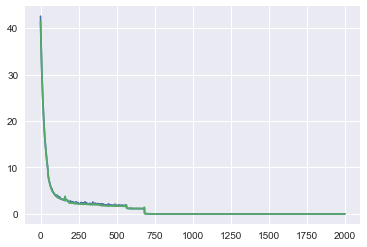

DONE!!


In [150]:
def Deep_ANN_Base(in_dim):
    model = Sequential()
    model.add(Dense(44, input_dim=in_dim, activation = 'relu', kernel_regularizer=regularizers.l2(.25)))
    model.add(BatchNormalization())
    model.add(Dense(22))
    model.add(BatchNormalization())
    model.add(Dense(11))
    model.add(BatchNormalization())
    model.add(Dense(6))
    model.add(BatchNormalization())
    model.add(Dense(3))
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(loss='mean_squared_logarithmic_error', optimizer=Adam(lr=0.00005, decay = 0))
    return model

clf = Deep_ANN_Base(feature_size)
history = clf.fit(feature,target, validation_split=0.1, shuffle=True, epochs= 2000, verbose=2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.show()

Pred = clf.predict(test).flatten().tolist()

# Inverse Transform to get actual Price
Pred = inv_boxcox(Pred,lmbda)

#Save
result =  pd.DataFrame({'Id':test_ID.Id,'SalePrice':Pred})
result.to_csv('upload_this_Final.csv', index= False)
print('DONE!!')

After adding Batch Normalization, the convergance speed changed significantly. So I had to use **learning rate decay**. But it didn't increase the accuracy. So I had to change the learning rate to implement Batch Normalization.
However, after a some more tuning, the accuracy increased a little bit.

Learning Rate | Kaggle Score | 
 ------------ |  :-----------: |
 0.000001 (Decay= 0 )| Did not converge|
      0.00001 (Decay= 0 )| Did not converge|
      0.001 (Decay= 0.0000005)| 0.1696 (Oscillates)|
      .0001 (Decay= 0 )| **0.13658** (Slow converge)| 

## 7.8. Activation Function

Some different activation functions were tried to find out the best one.

Activator | Kaggle Score | 
 ------------ |  :-----------: |
relu| **0.13658**|
linear| 0.13692|
Leaky Relu (.01)| 0.14| 

## 7.9. Epoch

The change of accuracy due to epoch was checked. But it was seen that the model get saturated in the training phase after about 1000 epochs. increasing the epoch to even 4000 didn't increase the accuracy. So, I fixed it at **2000**

# _8. Shallow Neural Network (Single Hidden Layer)_

After a while, It seamed like the highest capability of the present approach is saturated at around **0.13**. So I took a different approach toward the problem. That is- shallow network. Sometimes one hidden layer with large number of neurons can solve complex regression problems. This portion is inspired by **Julien Heiduk**'s publicly published kernel in kaggle. (https://www.kaggle.com/zoupet/neural-network-model-for-house-prices-tensorflow) The main portion of this code is written in tensorflow. So, we need to transform some data to special format. And for that need, the data is processsed in a different but simpler way. 

In [179]:
# Number of nodes
node_nb = 1200

#Validation Set ratio
TTR = .2

#Epoch
EPCH = 3000

#Reading the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Drop the ID
train.drop('Id',axis = 1, inplace = True)
ID = test.Id
test.drop('Id',axis = 1, inplace = True)

#isolate categorical and numeric features
train_numerical = train.select_dtypes(exclude=['object'])
train_categoric = train.select_dtypes(include=['object'])
test_numerical = test.select_dtypes(exclude=['object'])
test_categoric = test.select_dtypes(include=['object'])

#impute missing values
train_numerical.fillna(0,inplace = True)
train_categoric.fillna('NONE',inplace = True)
test_numerical.fillna(0,inplace = True)
test_categoric.fillna('NONE',inplace = True)

#Merge all features
train = train_numerical.merge(train_categoric, left_index = True, right_index = True) 
test = test_numerical.merge(test_categoric, left_index = True, right_index = True) 

#Outlier dropping
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train_numerical)
y_noano = clf.predict(train_numerical)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values
train_numerical = train_numerical.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_numerical.reset_index(drop = True, inplace = True)
train_categoric = train_categoric.iloc[y_noano[y_noano['Top'] == 1].index.values]
train_categoric.reset_index(drop = True, inplace = True)
train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)

#Get the column names
col_train_num = list(train_numerical.columns)
col_train_num_bis = list(train_numerical.columns)
col_train_cat = list(train_categoric.columns)

#remove the Target
col_train_num_bis.remove('SalePrice')

#Convert to numpy array (For scaling)
mat_train = np.matrix(train_numerical)
mat_test  = np.matrix(test_numerical)
mat_new = np.matrix(train_numerical.drop('SalePrice',axis = 1))
mat_y = np.array(train.SalePrice)

#Scaling the dataset
prepro_y = MinMaxScaler()
prepro_y.fit(mat_y.reshape(1314,1))

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

#Make new dataframe
train_num_scale = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test_num_scale  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_num_bis)
train[col_train_num] = pd.DataFrame(prepro.transform(mat_train),columns = col_train_num)
test[col_train_num_bis]  = test_num_scale

#Feature engineering / data transformation for tensorflow
COLUMNS = col_train_num
FEATURES = col_train_num_bis
LABEL = "SalePrice"
FEATURES_CAT = col_train_cat

engineered_features = []

for continuous_feature in FEATURES:
    engineered_features.append(
        tf.contrib.layers.real_valued_column(continuous_feature))

for categorical_feature in FEATURES_CAT:
    sparse_column = tf.contrib.layers.sparse_column_with_hash_bucket(
        categorical_feature, hash_bucket_size=1000)

    engineered_features.append(tf.contrib.layers.embedding_column(
        sparse_id_column=sparse_column, dimension=16,combiner="sum"))

training_set = train[FEATURES + FEATURES_CAT]
prediction_set = train.SalePrice

#Train Test Split
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES + FEATURES_CAT] ,
                                                    prediction_set, test_size=TTR, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES + FEATURES_CAT).merge(y_train, left_index = True, right_index = True)


training_sub = training_set[FEATURES + FEATURES_CAT]
testing_sub = test[FEATURES + FEATURES_CAT]


y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES + FEATURES_CAT).merge(y_test,
                                                                            left_index = True, right_index = True)

# Model
regressor = tf.contrib.learn.DNNRegressor(feature_columns = engineered_features, 
                                          activation_fn = tf.nn.relu, hidden_units=[node_nb])


#Treat numeric and categorical data differently with this function
def input_fn_new(data_set, training = True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
    
    categorical_cols = {k: tf.SparseTensor(
        indices=[[i, 0] for i in range(data_set[k].size)], 
        values = data_set[k].values, dense_shape = [data_set[k].size, 1]) for k in FEATURES_CAT}
    
    
    feature_cols = dict(list(continuous_cols.items()) + list(categorical_cols.items()))
    
    if training == True:
        label = tf.constant(data_set[LABEL].values)

        
        return feature_cols, label
    
    return feature_cols

#Fit the data to the model
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps= EPCH)

#Evaluate
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)
loss_score5 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score5))

#Predict
y_predict = regressor.predict(input_fn=lambda: input_fn_new(testing_sub, training = False))    

#CSV generator function
def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(prepro_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), 
                             columns = ['SalePrice'])
    y_predict = y_predict.join(ID)
    y_predict.to_csv(name_out + '.csv',index=False)

    
#Export result to csv
to_submit(y_predict, "upload_this")

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000214B0ADCF60>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\WETGLA~1\\AppData\\Local\\Temp\\tmpfpr7x29m'}


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\WETGLA~1\AppData\Local\Temp\tmpfpr7x29m\model.ckpt.
INFO:tensorflow:loss = 0.08670545, step = 1
INFO:tensorflow:global_step/sec: 20.1899
INFO:tensorflow:loss = 0.0028378433, step = 101 (4.937 sec)
INFO:tensorflow:global_step/sec: 23.5451
INFO:tensorflow:loss = 0.002284652, step = 201 (4.247 sec)
INFO:tensorflow:global_step/sec: 23.6377
INFO:tensorflow:loss = 0.0019931346, step = 301 (4.231 sec)
INFO:tensorflow:global_step/sec: 23.4723
INFO:tensorflow:loss = 0.0018049591, step = 401 (4.276 sec)
INFO:tensorflow:global_step/sec: 22.611
INFO:tensorflow:loss = 0.0016704435, step = 501 (4.407 sec)
INFO:tensorflow:global_step/sec: 26.9793
INFO:tensorflow:loss = 0.0015683812, step = 601 (3.711 sec)
INFO:tensorflow:global_step/sec: 26.0797
INFO:tensorflow:loss = 0.0014865742, step = 701 (3.830 sec)
INFO:tensorflow:global_step/sec: 24.9461
INFO:tensorflow:loss = 0.0014179049, step = 801 (4.009 sec)

INFO:tensorflow:loss = 0.00095889403, step = 2101 (3.847 sec)
INFO:tensorflow:global_step/sec: 26.1719
INFO:tensorflow:loss = 0.0009372307, step = 2201 (3.839 sec)
INFO:tensorflow:global_step/sec: 24.7884
INFO:tensorflow:loss = 0.0009162472, step = 2301 (4.018 sec)
INFO:tensorflow:global_step/sec: 26.5017
INFO:tensorflow:loss = 0.00089611294, step = 2401 (3.771 sec)
INFO:tensorflow:global_step/sec: 24.5812
INFO:tensorflow:loss = 0.00087702216, step = 2501 (4.079 sec)
INFO:tensorflow:global_step/sec: 25.8808
INFO:tensorflow:loss = 0.00085890514, step = 2601 (3.850 sec)
INFO:tensorflow:global_step/sec: 26.2637
INFO:tensorflow:loss = 0.0008414072, step = 2701 (3.808 sec)
INFO:tensorflow:global_step/sec: 25.8189
INFO:tensorflow:loss = 0.00082440727, step = 2801 (3.877 sec)
INFO:tensorflow:global_step/sec: 25.4906
INFO:tensorflow:loss = 0.00080815254, step = 2901 (3.922 sec)
INFO:tensorflow:Saving checkpoints for 3000 into C:\Users\WETGLA~1\AppData\Local\Temp\tmpfpr7x29m\model.ckpt.
INFO:te

INFO:tensorflow:Starting evaluation at 2018-02-21-16:10:52
INFO:tensorflow:Restoring parameters from C:\Users\WETGLA~1\AppData\Local\Temp\tmpfpr7x29m\model.ckpt-3000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-02-21-16:10:54
INFO:tensorflow:Saving dict for global step 3000: global_step = 3000, loss = 0.0014909012
Final Loss on the testing set: 0.001491
INFO:tensorflow:Restoring parameters from C:\Users\WETGLA~1\AppData\Local\Temp\tmpfpr7x29m\model.ckpt-3000


## Result Grid for Single Layer Neural Network

Node  | Validation Set Ratio| Epoch |Kaggle Score | 
 ------------ | :-----------: | :-----------: | :-----------: |
     2000 | 0.33 |2000| 0.12176 |
     1200 | 0.33  |2000| 0.12048 |
     1500 | 0.33  |2000| 0.12280 |
     1000 | 0.33  |2000| 0.12406 |
     2500 | 0.33  |2000| 0.12238 |
     1200 | 0.2  |2000| 0.11643 |
     1500 | 0.2  |2000| 0.11843 |
     1200 | 0.1  |2000| 0.12276 |
     1200 | 0.15  |2000| 0.11893 |
     **1200** | **0.2**  |**2500**| **0.11203** |
     1200 | 0.2 | 3000| 0.12068 |



## The best score is: 0.11203

# _9. Best Kaggle Score_
---

## The best score is: 0.11203
## Position in Kaggle when submitted: 28

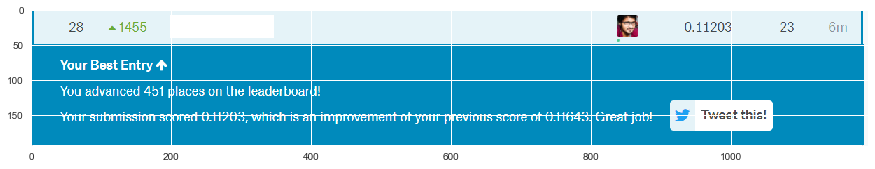

In [181]:
import matplotlib.image as mpimg
fig = plt.gcf()
img=mpimg.imread('result.png')
imgplot = plt.imshow(img)
fig.set_size_inches(15, 15)
plt.show()

# 10. Discussion
---

<ul>
<li>Neural Network has an inherent tendency to overfit. So, further tuning might be helpful.</li>
<li>Data Preprocessing had an huge impact on the model</li>
<li>Some more works might be done with the features with high NA.</li>
<li>Data Regularization had the most positive influence on the result when tried deep learning </li>
<li>Number of epochs, learning rate - etc are very influential hyperparametrs, though often ignored. </li>
</ul>

# 11. Conclusion
---


There is no theory or rule for determining the number of hidden layers or the number of nodes in each layer of a neural network. So, the work done above is kind of an impirical one. An extensive grid search is a very good option to tune the parameters. But as my machine is not that much powerful, this couldn't be done. But the overall flow was nearly optimum. There are some popular regression models, like XGBoost, which are good at prediction. Ensembling neural networks with these models may yield more accurate result.